In [42]:
import pickle

# load the scenario properties file
with open('../scenario-properties-collision.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)
    

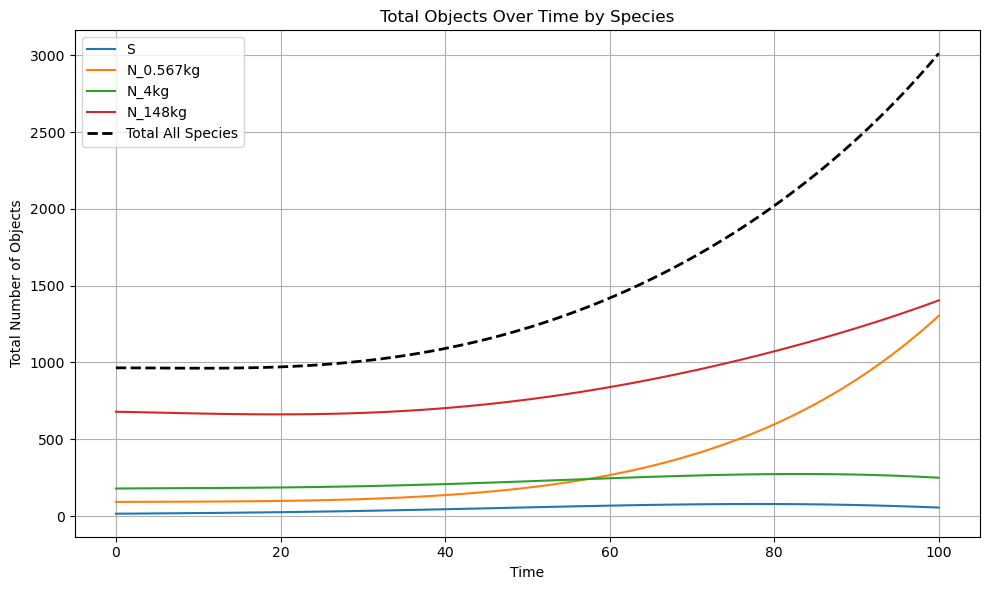

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack dimensions
n_shells = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = 10 # scenario_properties.eccentricity_bins -1 
n_time = scenario_properties.output.y.shape[1]
species_names = scenario_properties.species_names

# === Sum over all shells and eccentricity bins per species ===
plt.figure(figsize=(10, 6))
total_objects_all_species = np.zeros_like(scenario_properties.output.t)

for i in range(n_species):
    start_idx = i * n_shells * n_ecc_bins
    end_idx = start_idx + n_shells * n_ecc_bins
    total_objects_per_species = np.sum(scenario_properties.output.y[start_idx:end_idx, :], axis=0)

    plt.plot(scenario_properties.output.t, total_objects_per_species, label=f'{species_names[i]}')
    total_objects_all_species += total_objects_per_species

plt.plot(scenario_properties.output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Total Objects Over Time by Species')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
scenario_properties.time_in_shell[0, 0, :].sum()

1.0

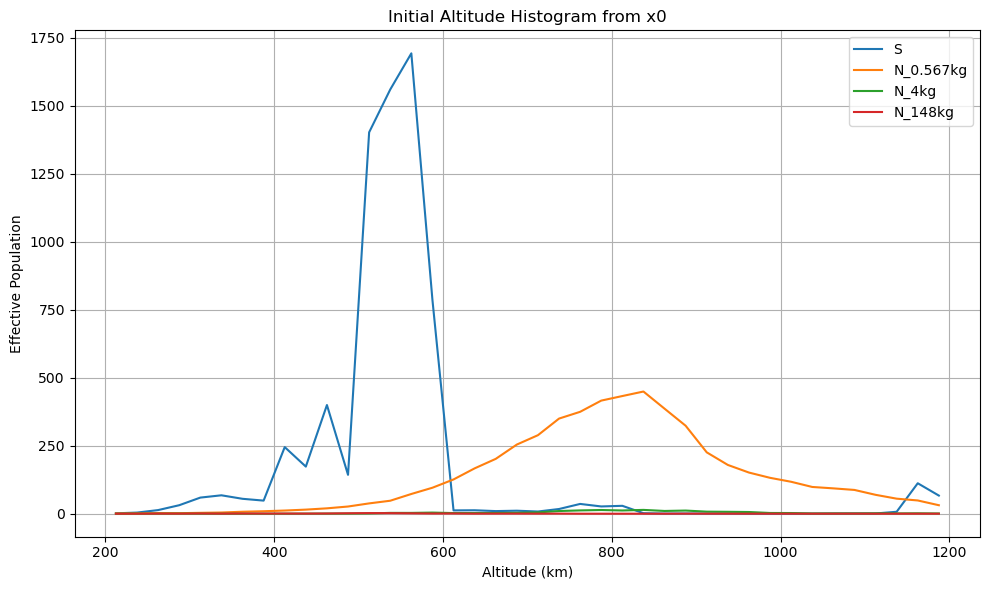

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack inputs
x0 = scenario_properties.x0  # shape: (sma, species, ecc)
TIS = scenario_properties.time_in_shell  # shape: (altitude, ecc, sma)
altitudes = scenario_properties.HMid  # length: n_alt_shells
species_names = scenario_properties.species_names

n_sma_bins, n_species, n_ecc_bins = x0.shape
n_alt_shells = TIS.shape[0]

# --- Calculate effective population in each altitude shell per species ---
effective_altitude_matrix = np.zeros((n_alt_shells, n_species))

for species in range(n_species):
    for alt_shell in range(n_alt_shells):
        total = 0.0
        for sma in range(n_sma_bins):
            for ecc in range(n_ecc_bins):
                n_pop = x0[sma, species, ecc]
                tis = TIS[alt_shell, ecc, sma]
                total += n_pop * tis
        effective_altitude_matrix[alt_shell, species] = total

# --- Plot: One line per species ---
plt.figure(figsize=(10, 6))
for s in range(n_species):
    plt.plot(altitudes, effective_altitude_matrix[:, s], label=species_names[s])

plt.xlabel("Altitude (km)")
plt.ylabel("Effective Population")
plt.title("Initial Altitude Histogram from x0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

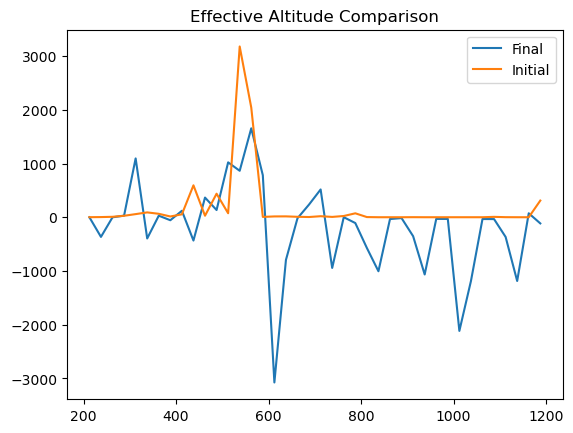

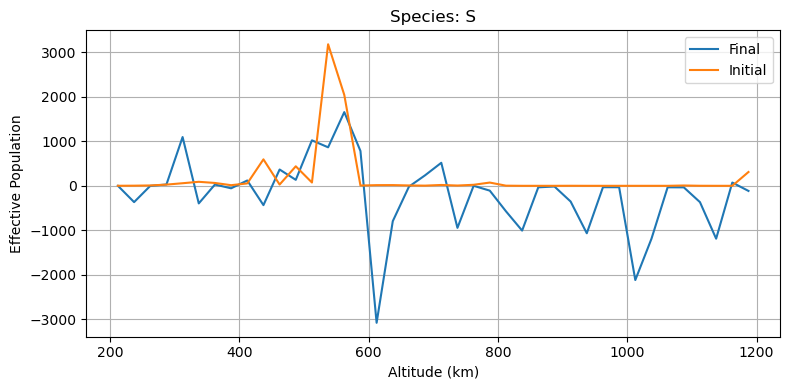

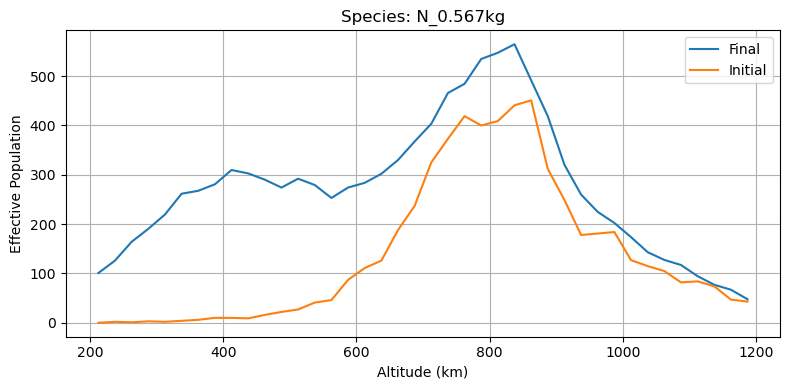

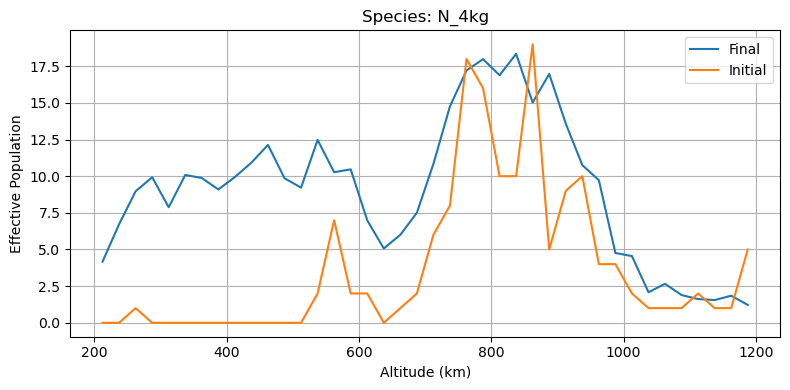

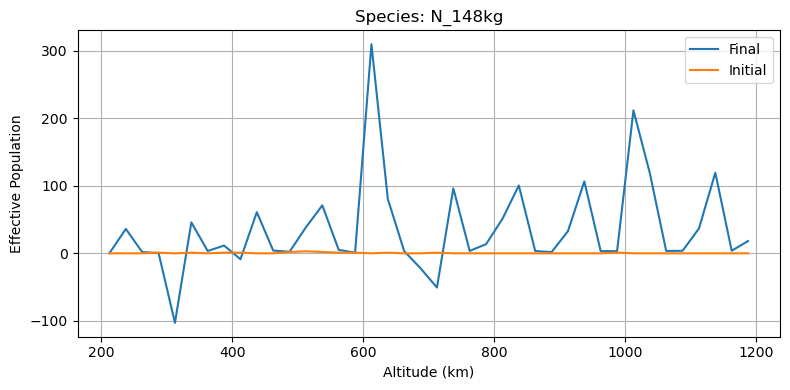

In [46]:
plt.plot(scenario_properties.HMid, scenario_properties.effective_altitude_matrix[:, 0], label='Final')
plt.plot(scenario_properties.HMid, scenario_properties.x0[:, 0, :].sum(axis=-1), label='Initial')
plt.legend(); plt.title("Effective Altitude Comparison"); plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Unpack
altitudes = scenario_properties.HMid
species_names = scenario_properties.species_names
x0 = scenario_properties.x0  # shape: (sma, species, ecc)
final = scenario_properties.effective_altitude_matrix  # shape: (altitude, species)

n_species = len(species_names)

# Plot for each species
for s in range(n_species):
    plt.figure(figsize=(8, 4))
    
    # Final effective altitude distribution
    plt.plot(altitudes, final[:, s], label="Final")
    
    # Initial distribution mapped to altitude by summing x0 over ecc
    initial = x0[:, s, :].sum(axis=-1)  # shape: (sma,)
    plt.plot(altitudes, initial, label="Initial")

    plt.title(f"Species: {species_names[s]}")
    plt.xlabel("Altitude (km)")
    plt.ylabel("Effective Population")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [47]:
scenario_properties.sma_ecc_mat_to_altitude_mat

<bound method ScenarioProperties.sma_ecc_mat_to_altitude_mat of <utils.simulation.scen_properties.ScenarioProperties object at 0x162090310>>

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_alt_shells = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
n_time = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # Altitude midpoints

# --- Unpack population data ---
y = scenario_properties.output.y
x_matrix = y.reshape(n_sma_bins, n_species, n_ecc_bins, n_time)  # shape: (sma, species, ecc, time)

# === Plotting ===
for s in range(n_species):
    n_eff_time = np.zeros((n_alt_shells, n_time))  # Altitude shells × time

    for t in range(n_time):
        pop_snapshot = x_matrix[:, s, :, t]  # shape: (sma, ecc)
        
        # Reconstruct full shape (sma, species, ecc) to use in converter
        pop_full = np.zeros((n_sma_bins, n_species, n_ecc_bins))
        pop_full[:, s, :] = pop_snapshot

        # Convert to altitude matrix using your method
        alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(pop_full)
        n_eff_time[:, t] = alt_proj[:, s]

    # Final year distribution
    final_year_dist = n_eff_time[:, -1]

    # --- Create subplot: Heatmap + Final Distribution ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Heatmap of effective population over time
    im = axes[0].imshow(n_eff_time, aspect='auto', origin='lower',
                        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
                        cmap='viridis')
    axes[0].set_title(f"{species_names[s]}: Effective Pop. Over Time")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Altitude (km)")
    plt.colorbar(im, ax=axes[0], label="Effective Population")

    # Right: Final year distribution
    axes[1].plot(final_year_dist, altitudes)
    axes[1].set_title("Final Year Distribution")
    axes[1].set_xlabel("Effective Population")
    axes[1].set_ylabel("Altitude (km)")
    axes[1].invert_yaxis()

    plt.suptitle(f"Species: {species_names[s]}", fontsize=14)
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

# Effective Altitude

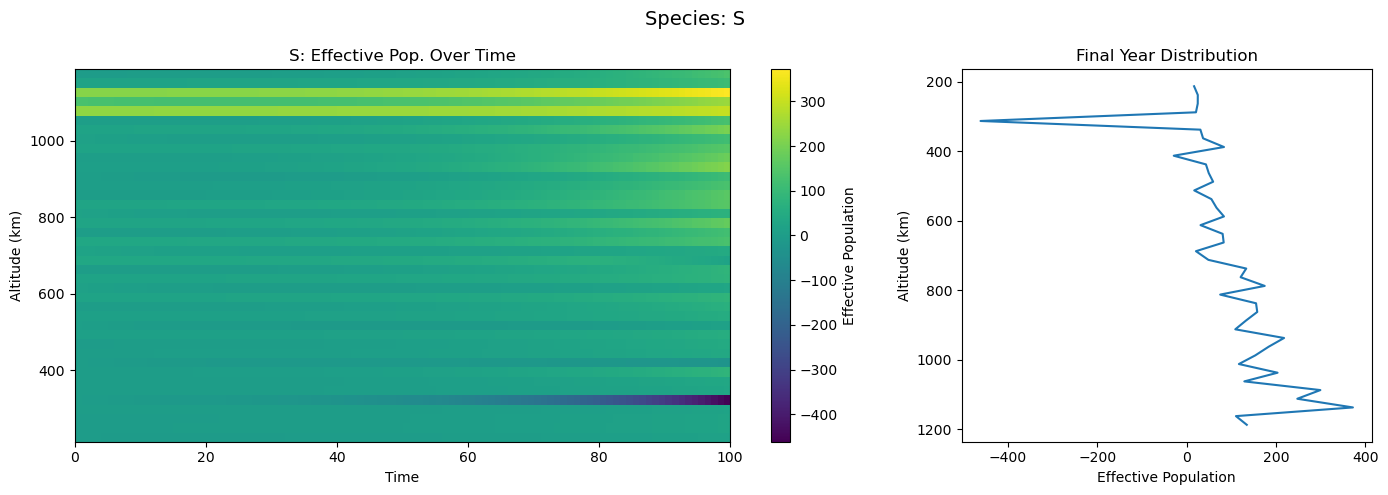

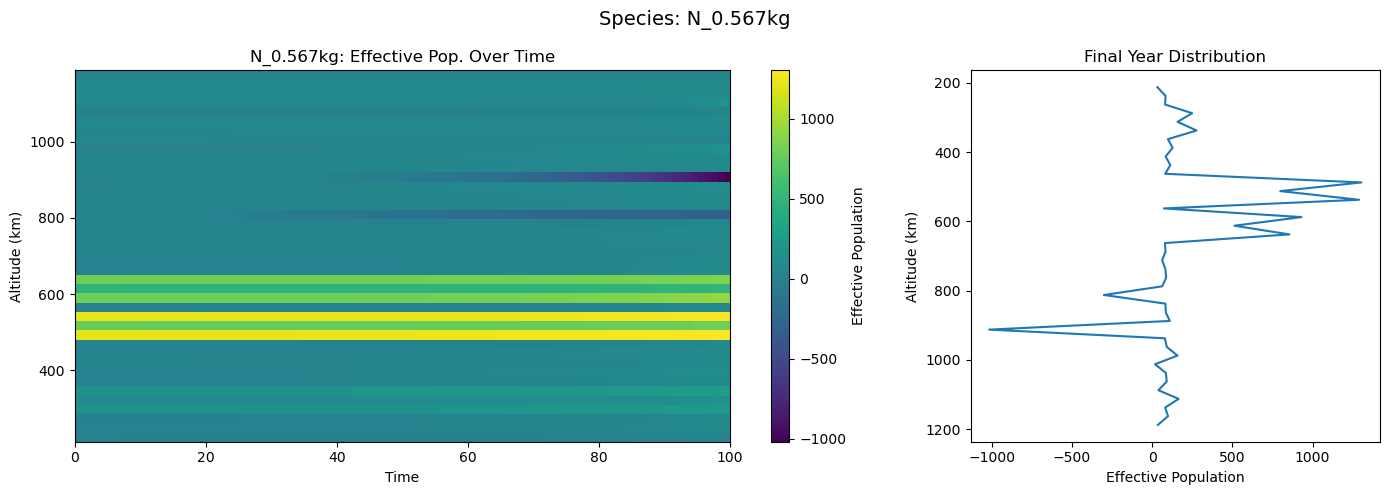

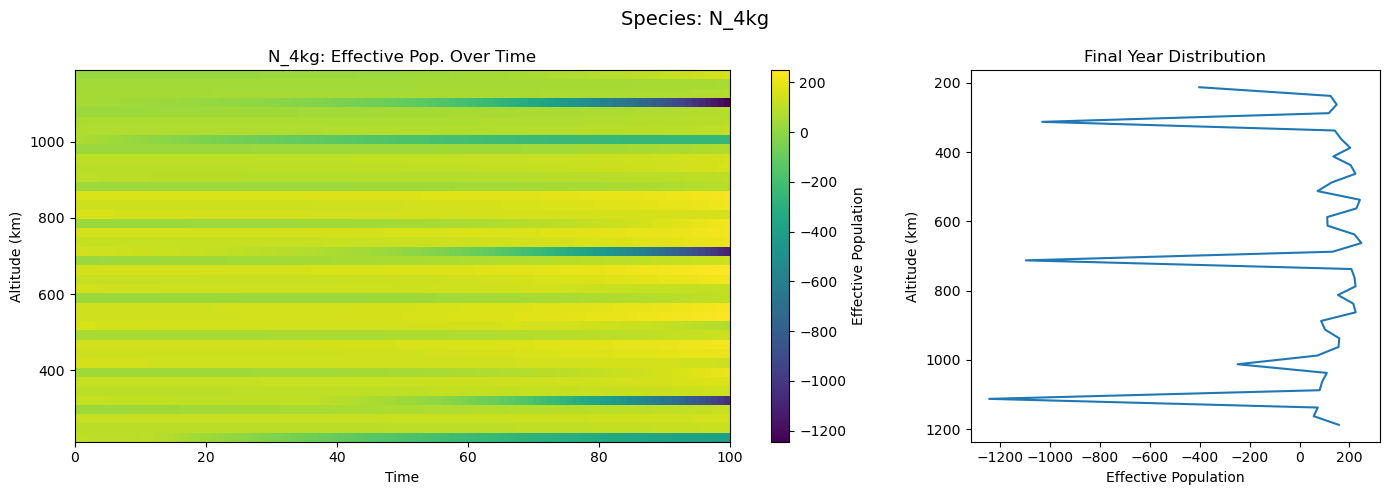

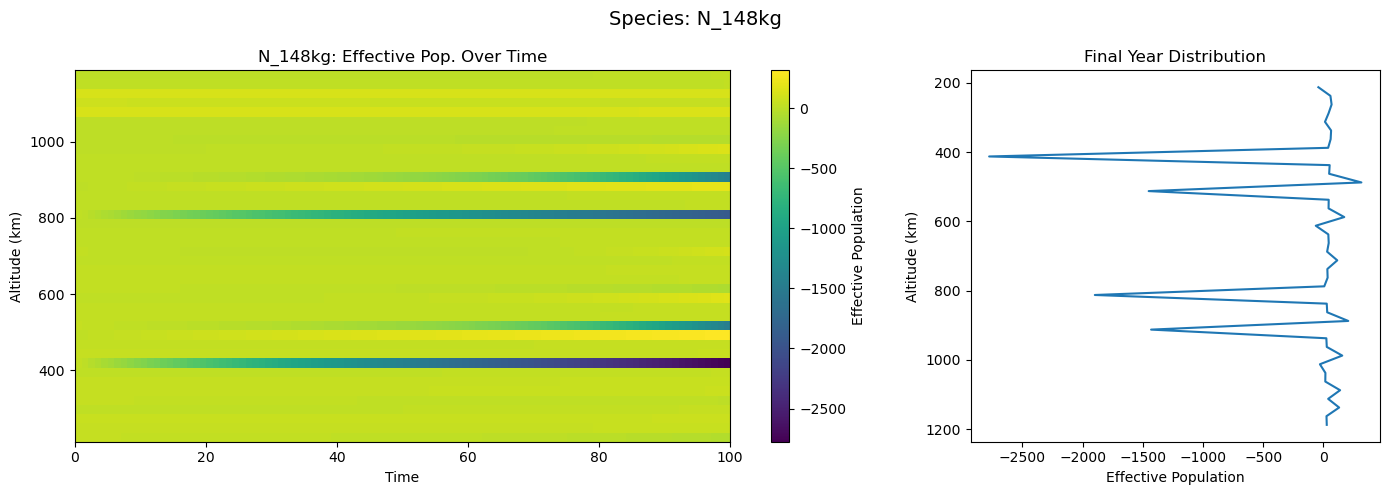

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_alt_shells = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_sma_bins = len(scenario_properties.semi_major_bins_km) - 1
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
n_time = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid
TIS = scenario_properties.time_in_shell  # shape: (alt_shell, ecc, sma)

# --- Unpack population data ---
y = scenario_properties.output.y
x_matrix = y.reshape(n_species, n_sma_bins, n_ecc_bins, n_time)  # ✅ fixed

# === Plotting ===
for s in range(n_species):
    n_eff_time = np.zeros((n_alt_shells, n_time))

    for t in range(n_time):
        pop = x_matrix[s, :, :, t]  # shape: (sma, ecc)

        for alt_shell in range(n_alt_shells):
            n_effective = 0.0
            for sma in range(n_sma_bins):
                for ecc in range(n_ecc_bins):
                    tis = TIS[alt_shell, ecc, sma]
                    n_pop = pop[sma, ecc]
                    n_effective += n_pop * tis
            n_eff_time[alt_shell, t] = n_effective

    final_year_dist = n_eff_time[:, -1]

    # === Plot ===
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Heatmap
    im = axes[0].imshow(n_eff_time, aspect='auto', origin='lower',
                        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
                        cmap='viridis')
    axes[0].set_title(f"{species_names[s]}: Effective Pop. Over Time")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Altitude (km)")
    plt.colorbar(im, ax=axes[0], label="Effective Population")

    # Right: Final year profile
    axes[1].plot(final_year_dist, altitudes)
    axes[1].set_title("Final Year Distribution")
    axes[1].set_xlabel("Effective Population")
    axes[1].set_ylabel("Altitude (km)")
    axes[1].invert_yaxis()

    plt.suptitle(f"Species: {species_names[s]}", fontsize=14)
    plt.tight_layout()
    plt.show()

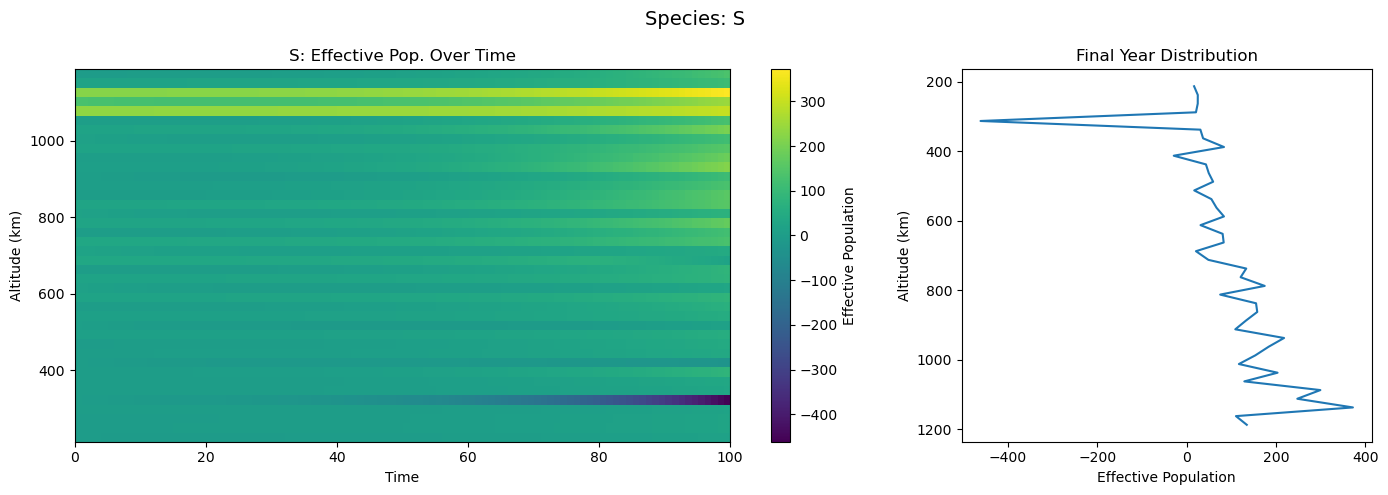

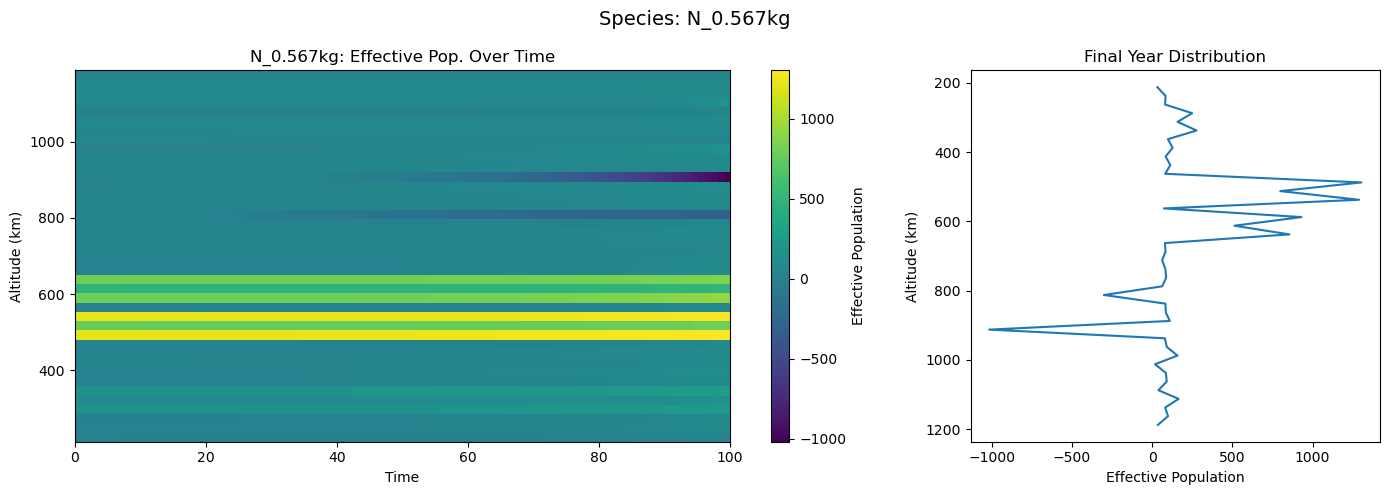

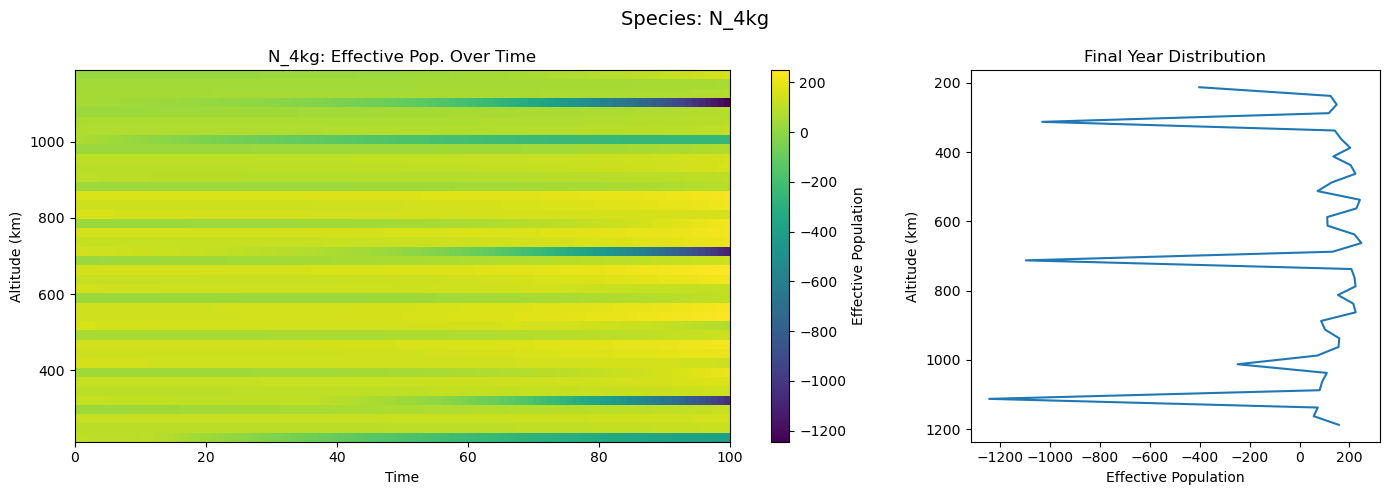

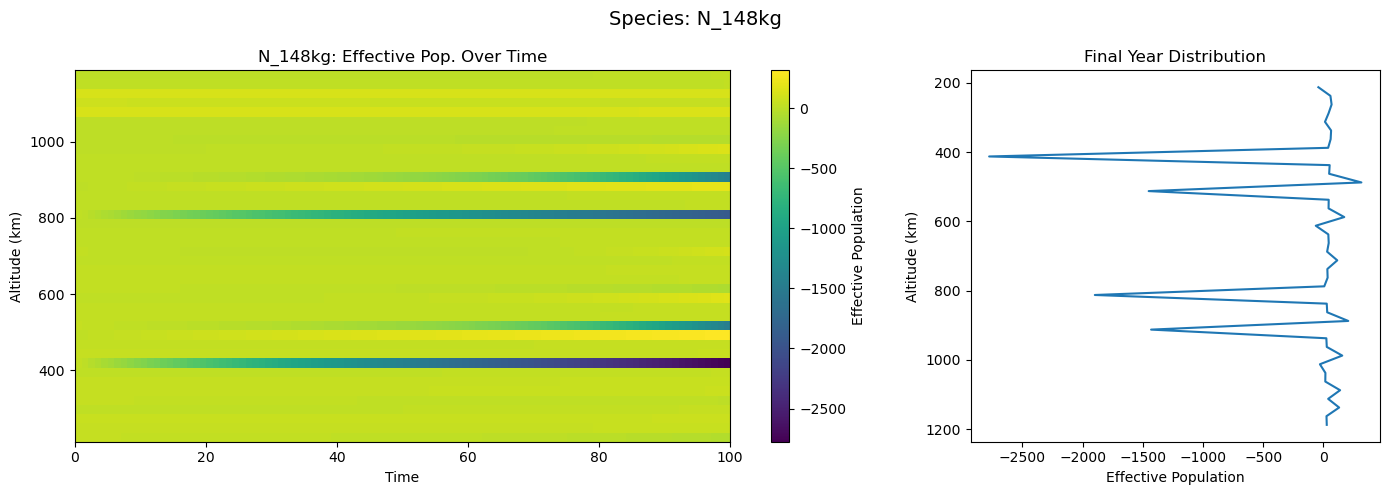

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_alt_shells = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_sma_bins = len(scenario_properties.semi_major_bins_km) - 1
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
n_time = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid
time_in_shell = scenario_properties.time_in_shell  # shape: (alt_shell, ecc, sma)

# --- Unpack population data ---
y = scenario_properties.output.y
x_matrix_time = y.reshape(n_species, n_alt_shells, n_ecc_bins, n_time)

# === Main Loop Over Species ===
for s in range(n_species):
    # Store effective population over time for this species
    eff_alt_time = np.zeros((n_alt_shells, n_time))

    for t in range(n_time):
        x_matrix = x_matrix_time[s, :, :, t]  # shape: (sma, ecc) at this timestep

        effective_altitude_matrix = np.zeros(n_alt_shells)
        normalised_species_distribution = np.zeros((n_alt_shells, n_sma_bins, n_ecc_bins))

        for alt_shell in range(n_alt_shells):
            n_effective = 0.0
            for sma in range(n_sma_bins):
                for ecc in range(n_ecc_bins):
                    tis = time_in_shell[alt_shell, ecc, sma]  # time in shell
                    n_pop = x_matrix[sma, ecc]               # population
                    n_effective_ae = n_pop * tis
                    n_effective += n_effective_ae
                    normalised_species_distribution[alt_shell, sma, ecc] = n_effective_ae

            if n_effective > 0:
                normalised_species_distribution[alt_shell, :, :] /= n_effective
            normalised_species_distribution[alt_shell, :, :] = np.nan_to_num(normalised_species_distribution[alt_shell, :, :])
            effective_altitude_matrix[alt_shell] = n_effective

        eff_alt_time[:, t] = effective_altitude_matrix

    # Final year slice
    final_year_dist = eff_alt_time[:, -1]

    # === Plot ===
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Heatmap of effective altitude population over time
    im = axes[0].imshow(eff_alt_time, aspect='auto', origin='lower',
                        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
                        cmap='viridis')
    axes[0].set_title(f"{species_names[s]}: Effective Pop. Over Time")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Altitude (km)")
    plt.colorbar(im, ax=axes[0], label="Effective Population")

    # Right: Final year distribution
    axes[1].plot(final_year_dist, altitudes)
    axes[1].set_title("Final Year Distribution")
    axes[1].set_xlabel("Effective Population")
    axes[1].set_ylabel("Altitude (km)")
    axes[1].invert_yaxis()

    plt.suptitle(f"Species: {species_names[s]}", fontsize=14)
    plt.tight_layout()
    plt.show()

Species: S, Data shape: (40, 40)
Species: N_0.567kg, Data shape: (40, 40)
Species: N_4kg, Data shape: (40, 40)
Species: N_148kg, Data shape: (40, 40)


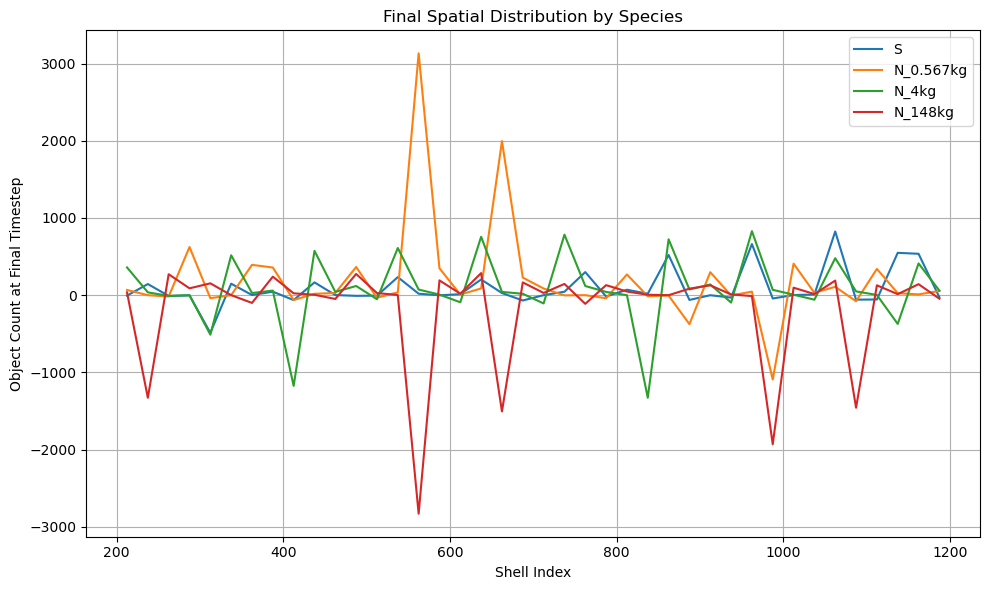

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack dimensions
n_shells = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = 40  # or len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
final_step_index = -1  # last timestep

# Optional: Use actual altitude midpoint values
try:
    altitude = scenario_properties.HMid  # shape: (n_shells,)
except AttributeError:
    altitude = np.arange(n_shells)  # fallback to shell index if not available

plt.figure(figsize=(10, 6))

for i in range(n_species):
    start_idx = i * n_shells * n_ecc_bins
    end_idx = start_idx + n_shells * n_ecc_bins
    data_species = scenario_properties.output.y[start_idx:end_idx, final_step_index]  # shape: (n_shells * n_ecc_bins,)

    # Reshape and sum over eccentricity bins
    data_species_reshaped = data_species.reshape(n_shells, n_ecc_bins)
    print(f"Species: {species_names[i]}, Data shape: {data_species_reshaped.shape}")
    shell_totals = np.sum(data_species_reshaped, axis=1)  # shape: (n_shells,)

    plt.plot(altitude, shell_totals, label=species_names[i])

plt.xlabel('Altitude (km)' if 'HMid' in locals() else 'Shell Index')
plt.ylabel('Object Count at Final Timestep')
plt.title('Final Spatial Distribution by Species')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
scenario_properties.output.y.shape

(6720, 100)

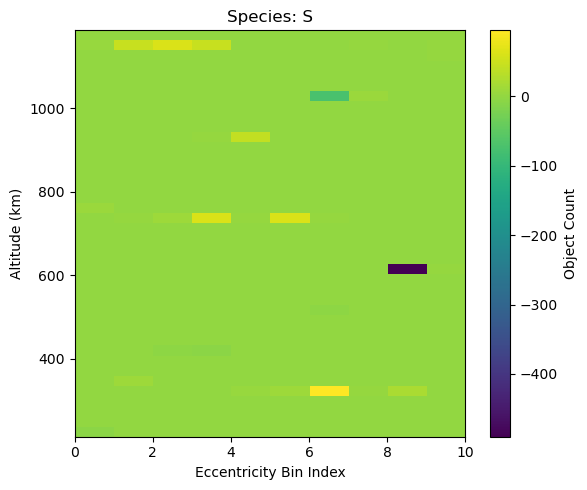

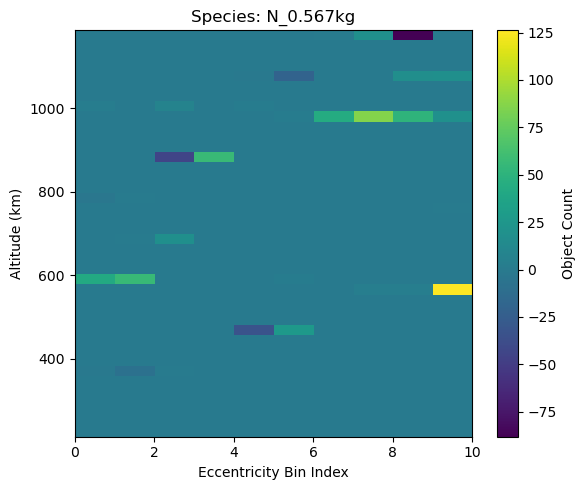

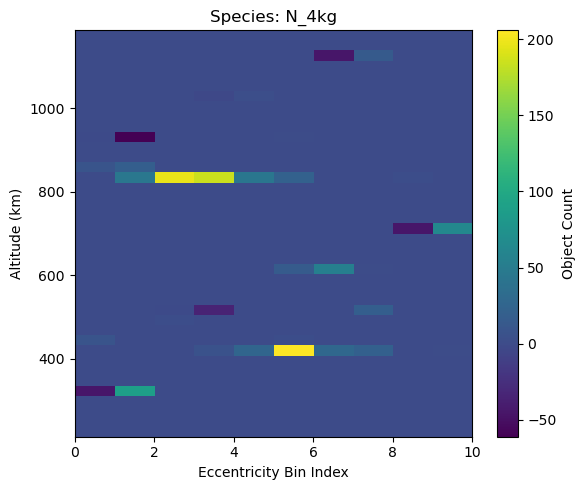

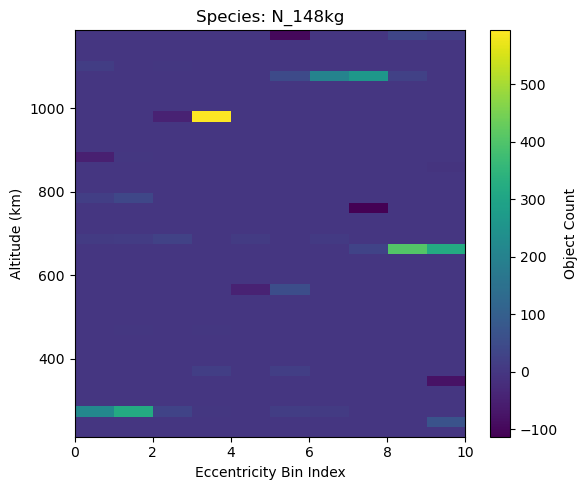

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack dimensions
n_shells = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = 10  # or len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
final_step_index = -1  # last timestep

# Get altitude for y-axis
try:
    altitude = scenario_properties.HMid
except AttributeError:
    altitude = np.arange(n_shells)

ecc_indices = np.arange(n_ecc_bins)

# Plot each species as a separate heatmap
for i in range(n_species):
    start_idx = i * n_shells * n_ecc_bins
    end_idx = start_idx + n_shells * n_ecc_bins
    data_species = scenario_properties.output.y[start_idx:end_idx, final_step_index]
    
    # Reshape to (n_shells, n_ecc_bins)
    heatmap = data_species.reshape(n_shells, n_ecc_bins)
    
    plt.figure(figsize=(6, 5))
    im = plt.imshow(
        heatmap,
        origin='lower',
        aspect='auto',
        cmap='viridis',
        extent=[ecc_indices[0], ecc_indices[-1]+1, altitude[0], altitude[-1]]
    )
    
    plt.colorbar(im, label='Object Count')
    plt.title(f"Species: {species_names[i]}")
    plt.xlabel("Eccentricity Bin Index")
    plt.ylabel("Altitude (km)")
    plt.tight_layout()
    plt.show()